In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Imports

In [2]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D,GRU, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout

import nltk
import re
from nltk.corpus import stopwords
from textblob import Word, TextBlob

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

### Load Dataset

In [3]:
train_df = pd.read_csv('/content/Constraint_Train.csv')
#train_df = pd.read_csv('../input/disastertweets/Constraint_Train.csv')

### Data Preprocessing

In [4]:
train_df = train_df[['tweet','label']]

In [5]:
dataframe = pd.DataFrame(train_df, columns = ['tweet', 'label'])
print("Given Dataframe :\n", dataframe) 

Given Dataframe :
                                                   tweet label
0     The CDC currently reports 99031 deaths. In gen...  real
1     States reported 1121 deaths a small rise from ...  real
2     Politically Correct Woman (Almost) Uses Pandem...  fake
3     #IndiaFightsCorona: We have 1524 #COVID testin...  real
4     Populous states can generate large case counts...  real
...                                                 ...   ...
6838                                                NaN   NaN
6839                                                NaN   NaN
6840                                                NaN   NaN
6841                                                NaN   NaN
6842                                                NaN  real

[6843 rows x 2 columns]


In [6]:
rslt_df = dataframe[dataframe['label'] == 'real']
rslt_df['label'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
fslt_df = dataframe[dataframe['label'] == 'fake']
fslt_df['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
frames = [fslt_df, rslt_df]
total = pd.concat(frames)
total

,tweet,label
2,Politically Correct Woman (Almost) Uses Pandem...,0
7,Obama Calls Trump’s Coronavirus Response A Cha...,0
8,"???Clearly, the Obama administration did not l...",0
9,Retraction—Hydroxychloroquine or chloroquine w...,0
11,The NBA is poised to restart this month. In Ma...,0
...,...,...
6405,The cloth face coverings recommended to slow s...,1
6411,The latest updates from the Ministry of Health...,1
6414,Data from #COVIDNET show that after a period o...,1
6419,It has been 93 days since the last case of COV...,1


In [9]:
total['label'].unique()

array([0, 1])

In [10]:
#train_df.drop(columns=['id'], axis=1, inplace=True)
print(train_df.shape)

(6843, 2)


In [11]:
train_df = total
type(train_df)

pandas.core.frame.DataFrame

In [12]:
train_df = train_df[train_df['tweet'].notnull()]

In [13]:
train_df['tweet']=train_df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train_df["tweet"]=train_df["tweet"].str.replace('[^\w\s]', '').replace('\d', '')

sw=stopwords.words('english')
train_df["tweet"]=train_df["tweet"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
train_df["tweet"]=train_df["tweet"].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))

train_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,tweet,label
2,politically correct woman almost us pandemic e...,0
7,obama call trump coronavirus response chaotic ...,0
8,clearly obama administration leave kind game p...,0
9,retractionhydroxychloroquine chloroquine witho...,0
11,nba poised restart month march reported utah j...,0


# Keras Embeddings

### Splitting Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_df['tweet'],train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4784,) (4784,) (1196,) (1196,)


### Tokenizing

In [15]:
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(X_train)

In [16]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
max_length = 120
trunc_type = 'post'
pad_type = 'post'

X_train_padded = pad_sequences(X_train, maxlen=max_length, truncating=trunc_type, padding=pad_type)
X_test_padded = pad_sequences(X_test, maxlen=max_length, truncating=trunc_type, padding=pad_type)

In [18]:
print(X_train_padded.shape, X_test_padded.shape)

(4784, 120) (1196, 120)


In [19]:
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))
y_train = np.array(y_train)
y_test = np.array(y_test)
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Model Creation

In [20]:
embedding_dim = 300

In [21]:
model = Sequential()
# define CNN model
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
#model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
model.add(Bidirectional(GRU(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 113, 32)           76832     
                                                                 
 bidirectional (Bidirectiona  (None, 113, 64)          12672     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 113, 64)           0         
                                                                 
 flatten (Flatten)           (None, 7232)              0         
                                                                 
 dense (Dense)               (None, 32)                231456    
                                                        

### Model Compilation

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(
    loss = "binary_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [24]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

In [25]:
ep = EarlyStopping(
    monitor='val_accuracy', 
    patience=7,
)

### Model Training

In [27]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
30/30 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.6368
Epoch 00001: val_accuracy improved from -inf to 0.69070, saving model to my_checkpoint.ckpt
30/30 [==============================] - 5s 168ms/step - loss: 0.6765 - accuracy: 0.6368 - val_loss: 0.6428 - val_accuracy: 0.6907
Epoch 2/25
30/30 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.7196
Epoch 00002: val_accuracy improved from 0.69070 to 0.71891, saving model to my_checkpoint.ckpt
30/30 [==============================] - 3s 94ms/step - loss: 0.5872 - accuracy: 0.7196 - val_loss: 0.5828 - val_accuracy: 0.7189
Epoch 3/25
30/30 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.7492
Epoch 00003: val_accuracy improved from 0.71891 to 0.74713, saving model to my_checkpoint.ckpt
30/30 [==============================] - 3s 94ms/step - loss: 0.5182 - accuracy: 0.7492 - val_loss: 0.5077 - val_accuracy: 0.7471
Epoch 4/25
30/30 [===========================

### Graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


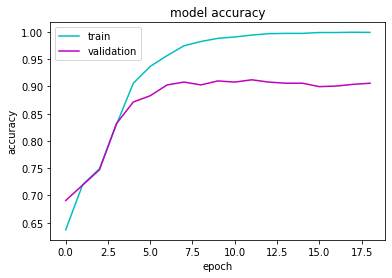

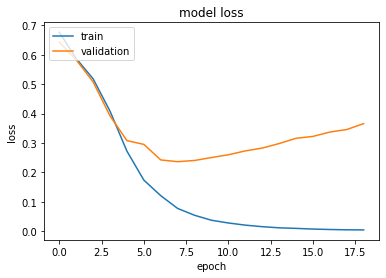

In [28]:
print(history.history.keys())
plt.axes().set(facecolor ="white")
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy').set_color('black')
plt.ylabel('accuracy').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.axes().set(facecolor ="white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss').set_color('black')
plt.ylabel('loss').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.show()

### Model Evaluation

In [29]:
model.evaluate(X_test_padded, y_test)

38/38 [==============================] - 1s 24ms/step - loss: 0.3660 - accuracy: 0.8997


[0.36598747968673706, 0.8996655344963074]

### Predicting Test Data

In [30]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

### Accuracy

In [31]:
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.8996655518394648


### Confusion Matrix

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.88818   0.91749   0.90260       606
           1    0.91228   0.88136   0.89655       590

    accuracy                        0.89967      1196
   macro avg    0.90023   0.89942   0.89957      1196
weighted avg    0.90007   0.89967   0.89962      1196



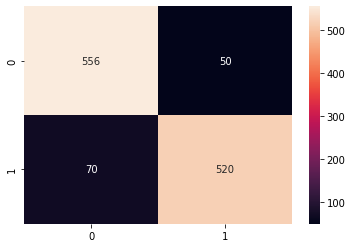

In [32]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

### Predicting new tweets

In [33]:
def preprocess_tweet(new_tweet):    
    new_tweet = new_tweet.lower()
    new_tweet = re.sub('[^\w\s]', '', new_tweet)
    new_tweet = re.sub('\d', '', new_tweet)

    new_tweet = " ".join(x for x in new_tweet.split() if x not in sw)
    new_tweet = " ".join([Word(word).lemmatize() for word in new_tweet.split()])
    print("On preprocessing:", new_tweet)
    
    tokenizer.fit_on_texts(new_tweet)

    new_tweet = tokenizer.texts_to_sequences([new_tweet])

    new_tweet =  pad_sequences(new_tweet, maxlen=max_length, truncating=trunc_type, padding=pad_type)

    return new_tweet

def predict_newTweet(tweet):
    print("Input Tweet: ", tweet)
    emb_tweet = preprocess_tweet(tweet)
    result = (model.predict(emb_tweet) > 0.5).astype("int32")
#     print(result)
    print("Output: " + "Real News" if result[0][0] == 1 else "Fake News")


In [34]:
new_tweet = "There is a treasure hidden beside the lake"
predict_newTweet(new_tweet)

Input Tweet:  There is a treasure hidden beside the lake
On preprocessing: treasure hidden beside lake
Fake News


In [37]:
new_tweet = "Please Wear a mask when you step out.Masks are important to protect us from corona virus Maintain social distancing. 300 today are vaccinated. Get your vaccine when its your turn"
predict_newTweet(new_tweet)

Input Tweet:  Please Wear a mask when you step out.Masks are important to protect us from corona virus Maintain social distancing. 300 today are vaccinated. Get your vaccine when its your turn
On preprocessing: please wear mask step outmasks important protect u corona virus maintain social distancing today vaccinated get vaccine turn
Output: Real News


# Word2Vec Exploration

In [38]:
import gensim
X = [d.split() for d in train_df['tweet'].tolist()]
DIM = 300
w2v_model = gensim.models.Word2Vec(sentences = X, size = DIM, window = 10, min_count = 1)

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen = 120)
vocab_size = len(tokenizer.word_index) + 1

In [40]:
vocab = tokenizer.word_index
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))

    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [41]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape
max_length = 120

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D
model = Sequential()
model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = max_length, trainable = True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(LSTM(32, return_sequences=True))
#model.add(Bidirectional(GRU(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4784, 120) (4784,) (1196, 120) (1196,)


In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7,)

In [45]:
epochs=25
history = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
29/30 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6533
Epoch 00001: val_accuracy improved from -inf to 0.68861, saving model to my_checkpoint.ckpt
30/30 [==============================] - 7s 83ms/step - loss: 0.6470 - accuracy: 0.6546 - val_loss: 0.6316 - val_accuracy: 0.6886
Epoch 2/25
29/30 [============================>.] - ETA: 0s - loss: 0.6014 - accuracy: 0.7225
Epoch 00002: val_accuracy improved from 0.68861 to 0.71473, saving model to my_checkpoint.ckpt
30/30 [==============================] - 1s 42ms/step - loss: 0.6007 - accuracy: 0.7241 - val_loss: 0.5854 - val_accuracy: 0.7147
Epoch 3/25
29/30 [============================>.] - ETA: 0s - loss: 0.5569 - accuracy: 0.7357
Epoch 00003: val_accuracy improved from 0.71473 to 0.72623, saving model to my_checkpoint.ckpt
30/30 [==============================] - 1s 44ms/step - loss: 0.5552 - accuracy: 0.7374 - val_loss: 0.5538 - val_accuracy: 0.7262
Epoch 4/25
30/30 [============================

In [46]:
model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 8ms/step - loss: 0.3821 - accuracy: 0.8921


[0.38206419348716736, 0.8921404480934143]

In [47]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.8921404682274248


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.90084   0.88449   0.89259       606
           1    0.88353   0.90000   0.89169       590

    accuracy                        0.89214      1196
   macro avg    0.89218   0.89224   0.89214      1196
weighted avg    0.89230   0.89214   0.89214      1196



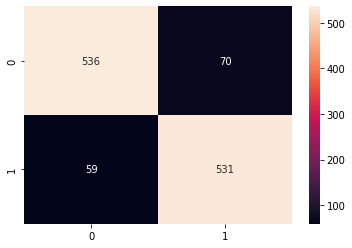

In [48]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# Glove Exploration

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
X_train, X_test, y_train, y_test = train_test_split(train_df['tweet'],train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4784,) (4784,) (1196,) (1196,)


In [51]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [52]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map

In [53]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/a_fake_news_detection/glove.6B.50d.txt')
maxLen = 120

In [54]:
vocab_len = len(words_to_index) + 1
embed_vector_len = word_to_vec_map['moon'].shape[0]
emb_matrix = np.zeros((vocab_len, embed_vector_len))
for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

#embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [55]:
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [56]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 50)           738350    
                                                                 
 conv1d_2 (Conv1D)           (None, 113, 32)           12832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 56, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 56, 64)           12672     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 3584)              0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [59]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
30/30 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.6057
Epoch 00001: val_accuracy improved from -inf to 0.70219, saving model to my_checkpoint.ckpt
30/30 [==============================] - 7s 76ms/step - loss: 0.6690 - accuracy: 0.6057 - val_loss: 0.6379 - val_accuracy: 0.7022
Epoch 2/25
29/30 [============================>.] - ETA: 0s - loss: 0.5927 - accuracy: 0.7349
Epoch 00002: val_accuracy improved from 0.70219 to 0.70637, saving model to my_checkpoint.ckpt
30/30 [==============================] - 1s 35ms/step - loss: 0.5913 - accuracy: 0.7353 - val_loss: 0.5836 - val_accuracy: 0.7064
Epoch 3/25
29/30 [============================>.] - ETA: 0s - loss: 0.5314 - accuracy: 0.7476
Epoch 00003: val_accuracy improved from 0.70637 to 0.72518, saving model to my_checkpoint.ckpt
30/30 [==============================] - 1s 36ms/step - loss: 0.5305 - accuracy: 0.7478 - val_loss: 0.5362 - val_accuracy: 0.7252
Epoch 4/25
29/30 [============================

In [60]:
model.evaluate(X_test_padded, y_test)

38/38 [==============================] - 1s 12ms/step - loss: 0.3220 - accuracy: 0.8587


[0.3220472037792206, 0.8586956262588501]

In [61]:
predictions = (model.predict(X_test_padded) >= 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.8586956521739131


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.88401   0.83003   0.85617       606
           1    0.83573   0.88814   0.86113       590

    accuracy                        0.85870      1196
   macro avg    0.85987   0.85908   0.85865      1196
weighted avg    0.86019   0.85870   0.85862      1196



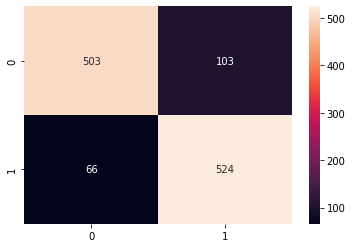

In [62]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# BERT Exploration

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df['tweet'],train_df['label'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4784,) (4784,) (1196,) (1196,)


In [ ]:
bert_abstract = ""
for sent in X_train:
    bert_abstract += sent +" "

In [ ]:
len(bert_abstract)

613822

In [ ]:
!pip install transformers -U

     |████████████████████████████████| 3.4 MB 608 kB/s            
  Attempting uninstall: transformers
    Found existing installation: transformers 4.12.5
    Uninstalling transformers-4.12.5:
      Successfully uninstalled transformers-4.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.8.0 requires transformers<4.13,>=4.1, but you have transformers 4.15.0 which is incompatible.


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = tf.constant(tokenizer.encode(bert_abstract))[None, :6000]  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2021-12-26 16:37:23.230278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 16:37:23.231862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 16:37:23.232840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 16:37:23.234081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
import numpy as np
emb_matrix = np.array(last_hidden_states)
emb_matrix = emb_matrix[0]

In [ ]:
emb_matrix.shape

(6000, 768)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [ ]:
maxLen = 120
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [ ]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=6000, output_dim=768, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [ ]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
30/30 [==============================] - 4s 36ms/step - loss: 0.6451 - accuracy: 0.6423 - val_loss: 0.5883 - val_accuracy: 0.7043

Epoch 00001: val_accuracy improved from -inf to 0.70428, saving model to my_checkpoint.ckpt
Epoch 2/25
30/30 [==============================] - 1s 18ms/step - loss: 0.5634 - accuracy: 0.7303 - val_loss: 0.5581 - val_accuracy: 0.7252

Epoch 00002: val_accuracy improved from 0.70428 to 0.72518, saving model to my_checkpoint.ckpt
Epoch 3/25
30/30 [==============================] - 1s 19ms/step - loss: 0.5363 - accuracy: 0.7361 - val_loss: 0.5406 - val_accuracy: 0.7346

Epoch 00003: val_accuracy improved from 0.72518 to 0.73459, saving model to my_checkpoint.ckpt
Epoch 4/25
30/30 [==============================] - 1s 23ms/step - loss: 0.5260 - accuracy: 0.7486 - val_loss: 0.5292 - val_accuracy: 0.7471

Epoch 00004: val_accuracy improved from 0.73459 to 0.74713, saving model to my_checkpoint.ckpt
Epoch 5/25
30/30 [==============================] - 1s 

In [ ]:
model.evaluate(X_test_padded, y_test)

38/38 [==============================] - 0s 5ms/step - loss: 0.3302 - accuracy: 0.8913


[0.33015817403793335, 0.8913043737411499]

In [ ]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.87898   0.91089   0.89465       606
           1    0.90493   0.87119   0.88774       590

    accuracy                        0.89130      1196
   macro avg    0.89196   0.89104   0.89119      1196
weighted avg    0.89178   0.89130   0.89124      1196



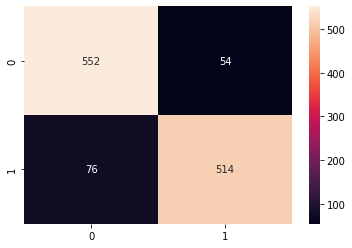

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))